<a href="https://colab.research.google.com/github/ispineda/Bedu-Santander/blob/main/Python-Analytics/F3_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sesion 7: Pruebas A/B y Procesamiento de Lenguaje Natural

### Ejemplo 1: Pruebas A/B

1. Objetivos:
    - Aprender a evaluar los resultados de una Prueba A/B
 
---
    
2. Desarrollo:

El siguiente es un dataset obtenido con los resultados de una Prueba A/B. Se probaron dos flujos de venta distintos y se registró si cada uno de ellos resultó en una conversión (venta) o no. El test A es la hipótesis alternativa (la aplicada al grupo experimental), mientras que el test B es la hipótesis nula (la aplicada al grupo control).

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Remoto Datasets/Remoto ab_test-sales_pipeline.csv')

df

,test,conversion,no conversion
0,B,0,1
1,A,0,1
2,A,0,1
3,A,0,1
4,A,0,1
...,...,...,...
46322,B,0,1
46323,B,0,1
46324,B,0,1
46325,A,0,1


Lo primero que podemos hacer es agrupar nuestros resultados por 'test', para realizar un conteo de cuántas conversiones hubo con cada flujo de ventas:

In [ ]:
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()

total_count

,conversion,no conversion
test,,
A,198,23541
B,184,22404


Saquemos la proporción de conversiones que hubo comparadas con el total de pruebas que se realizaron:

In [ ]:
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])

total_count

,conversion,no conversion,success rate
test,,,
A,198,23541,0.008341
B,184,22404,0.008146


Con estos datos parecería que el flujo A (la hipótesis alternativa) es superior al flujo B. Veamos qué tan superior:

In [ ]:
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100

In [ ]:
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más `efectivo que el test B para generar ventas.')

El test A fue 2.34% más `efectivo que el test B para generar ventas.


¿Ahora, podemos entonces concluir que el flujo de ventas A es mejor que el B? No tan rápido. Vamos a aplicar un test de permutación para saber si nuestro hallazgo es estadísticamente significativo.

Primero tenemos que mezclar las mediciones del test A y el B en el mismo DataFrame. Esto ya está hecho, entonces solamente vamos a eliminar la columna 'test' para que no haya manera de diferenciarlos:

In [ ]:
all_measurements = df[['conversion', 'no conversion']]

Ahora necesitamos saber cuántos tests con el flujo A hubieron para poder generar muestras del mismo tamaño exactamente:

In [ ]:
value_counts = df['test'].value_counts()

value_counts

A    23739
B    22588
Name: test, dtype: int64

Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.

In [ ]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['A'], replace=False)
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    b = df.loc[~df.index.isin(a.index)]
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

In [ ]:
perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b
0,215,23524,167,22421
1,193,23546,189,22399
2,195,23544,187,22401
3,208,23531,174,22414
4,184,23555,198,22390
...,...,...,...,...
995,194,23545,188,22400
996,196,23543,186,22402
997,185,23554,197,22391
998,211,23528,171,22417


In [ ]:
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [ ]:
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,215,23524,167,22421,0.009057,0.007393
1,193,23546,189,22399,0.008130,0.008367
2,195,23544,187,22401,0.008214,0.008279
3,208,23531,174,22414,0.008762,0.007703
4,184,23555,198,22390,0.007751,0.008766
...,...,...,...,...,...,...
995,194,23545,188,22400,0.008172,0.008323
996,196,23543,186,22402,0.008256,0.008234
997,185,23554,197,22391,0.007793,0.008721
998,211,23528,171,22417,0.008888,0.007570


In [ ]:
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,215,23524,167,22421,0.009057,0.007393,0.183676
1,193,23546,189,22399,0.008130,0.008367,-0.029175
2,195,23544,187,22401,0.008214,0.008279,-0.007840
3,208,23531,174,22414,0.008762,0.007703,0.120835
4,184,23555,198,22390,0.007751,0.008766,-0.130920
...,...,...,...,...,...,...,...
995,194,23545,188,22400,0.008172,0.008323,-0.018452
996,196,23543,186,22402,0.008256,0.008234,0.002664
997,185,23554,197,22391,0.007793,0.008721,-0.119126
998,211,23528,171,22417,0.008888,0.007570,0.148277


Ya tenemos nuestros resultados, vamos a ver dónde cae en nuestra distribución el resultado que obtuvimos en nuestro experimento:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


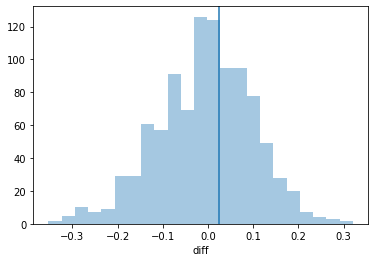

In [ ]:
sns.distplot(perm_results['diff'], kde=False, norm_hist=False)

plt.axvline(diferencia_en_proporcion);

Solamente de ver la histograma podemos concluir que nuestro resultado es de hecho bastante típico. Un gran número de modelos realizados totalmente al azar tuvieron valores iguales o más extremos que el que obtuvimos en nuestro experimento.

Vamos ahora a obtener el Valor P para cuantificar numéricamente nuestro resultado:

In [ ]:
(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0]

0.428

Este valor quiere decir que el 41.6% de los test que hicimos obtuvieron un valor igual o más extremo que el obtenido en el experimento. Esto está extremadamente alejado de un Alfa de 5%, y por lo tanto definitivamente nuestro resultado **no es estadísticamente significativo**.

### Ejemplo 2: Regex

1. Objetivos:
    - Repasar algunas reglas básicas de las Expresiones Regulares y su aplicación usando pandas
 
---
    
2. Desarrollo:

Ya conoces seguramente las Expresiones Regulares. Las expresiones regulares o regex son secuencias de caracteres que definen un patrón de búsqueda. Son una manera de describirle a nuestros programas qué patrones estamos buscando en nuestros datos.

Las expresiones regulares resultan sumamente útiles para trabajar con lenguaje natural. Vamos a repasar algunas de las reglas de las regex y a aprender a aplicarlas usando pandas.

Para esto utilizaremos el dataset 'new_york_times_bestsellers-clean.json' que contiene datos acerca de libros que han sido seleccionados como bestsellers del New York Times.

In [ ]:
import pandas as pd
import re

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Remoto Datasets/Remoto new_york_times_bestsellers-clean.json')

df.head()

,amazon_product_url,author,description,publisher,title,oid,bestsellers_date.numberLong,published_date.numberLong,rank.numberInt,rank_last_week.numberInt,weeks_on_list.numberInt,price.numberDouble
0,http://www.amazon.com/The-Host-Novel-Stephenie...,Stephenie Meyer,Aliens have taken control of the minds and bod...,"Little, Brown",THE HOST,5b4aa4ead3089013507db18c,1211587200000,1212883200000,2,1,3,25.99
1,http://www.amazon.com/Love-Youre-With-Emily-Gi...,Emily Giffin,A woman's happy marriage is shaken when she en...,St. Martin's,LOVE THE ONE YOU'RE WITH,5b4aa4ead3089013507db18d,1211587200000,1212883200000,3,2,2,24.95
2,http://www.amazon.com/The-Front-Garano-Patrici...,Patricia Cornwell,A Massachusetts state investigator and his tea...,Putnam,THE FRONT,5b4aa4ead3089013507db18e,1211587200000,1212883200000,4,0,1,22.95
3,http://www.amazon.com/Snuff-Chuck-Palahniuk/dp...,Chuck Palahniuk,An aging porn queens aims to cap her career by...,Doubleday,SNUFF,5b4aa4ead3089013507db18f,1211587200000,1212883200000,5,0,1,24.95
4,http://www.amazon.com/Sundays-at-Tiffanys-Jame...,James Patterson and Gabrielle Charbonnet,A woman finds an unexpected love,"Little, Brown",SUNDAYS AT TIFFANY’S,5b4aa4ead3089013507db190,1211587200000,1212883200000,6,3,4,24.99


In [ ]:
grouped_by_title = df.groupby('title')['description'].max()

grouped_by_title

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1356                        In the fourth book of the Grail Quest series, ...
1Q84                        In 1980s Tokyo, a woman who punishes perpetrat...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F. Sco...
ZERO DAY                       A military investigator uncovers a conspiracy.
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

Hay varias entradas para los mismos libros, así que los he agrupado por título. En la columna 'description' tenemos descripciones de los libros en nuestro dataset. Resulta un conjunto de datos interesante, puesto que podemos entender qué tipo de libros son los que se convierten en bestsellers del New York Times.

**Patrones de Regex**

Vamos a utilizar este dataset para repasar algunas maneras de definir patrones usando regex.

In [ ]:
# Buscar una palabra en un texto

grouped_by_title[grouped_by_title.str.contains('woman', case=False)]

title
1Q84                      In 1980s Tokyo, a woman who punishes perpetrat...
A CEDAR COVE CHRISTMAS    A pregnant woman shows up in Cedar Cove on Chr...
A CHANGE IN ALTITUDE      A young woman’s life is transformed by a mount...
A TURN IN THE ROAD        A middle-age woman takes a cross-country road ...
AN OBJECT OF BEAUTY       A young, beautiful and ambitious woman ruthles...
                                                ...                        
THIS BODY OF DEATH        Detective Thomas Lynley becomes involved when ...
THOSE IN PERIL            A private security agent battles pirates who h...
WHAT DOESN'T KILL YOU     A Hong Kong woman who works for the C.I.A. sea...
WHERE WE BELONG           A woman’s successful life is disrupted by the ...
WHILE MY SISTER SLEEPS    A woman makes discoveries about her sister and...
Name: description, Length: 74, dtype: object

In [ ]:
# Buscar la aparición de números del 0 al 9

grouped_by_title[grouped_by_title.str.contains('[0-9]')]

title
1Q84                          In 1980s Tokyo, a woman who punishes perpetrat...
2030                          In 2030, the young resent the elderly for drai...
A LESSON IN SECRETS           In the summer of 1932, Maisie Dobbs’s first as...
A MEMORY OF LIGHT             The 14th and final novel in the Wheel of Time ...
A MERCY                       In 17th-­century America, a slave mother urges...
                                                    ...                        
WAKING THE WITCH                 Book 11 of the Women of the Otherworld series.
WHERE WE BELONG               A woman’s successful life is disrupted by the ...
WHERE'D YOU GO, BERNADETTE    A renowned and reclusive Seattle architect dis...
WHITE WITCH, BLACK CURSE      A witch who is also a bounty hunter avenges he...
WORST CASE                    A New York detective raising 10 children alone...
Name: description, Length: 123, dtype: object

In [ ]:
# Uno o más números seguidos por una o más letras

grouped_by_title[grouped_by_title.str.contains('[0-9]+[a-z]+', case=False)]

title
1Q84                                        In 1980s Tokyo, a woman who punishes perpetrat...
A MEMORY OF LIGHT                           The 14th and final novel in the Wheel of Time ...
A MERCY                                     In 17th-­century America, a slave mother urges...
A MIGHTY FORTRESS                           Book 4 of the Safehold series, which translate...
ANGEL TIME                                  \nA contract killer goes back to 13th-century ...
ANOTHER PIECE OF MY HEART                   A woman in her late 30s marries the man of her...
ARCTIC DRIFT                                In his 20th adventure, Dirk Pitt searches for ...
BONES ARE FOREVER                           The forensic anthropologist Temperance Brennan...
BREAKING POINT                              The 13th novel featuring Joe Pickett, a Wyomin...
DAMAGE CONTROL                              An elderly couple’s suicide-by-accident in the...
DARK STORM                                  In the 23r

In [ ]:
# Uno o más números seguidos por las letras 'th'

grouped_by_title[grouped_by_title.str.contains('[0-9]th', case=False)]

title
A MEMORY OF LIGHT                           The 14th and final novel in the Wheel of Time ...
A MERCY                                     In 17th-­century America, a slave mother urges...
A MIGHTY FORTRESS                           Book 4 of the Safehold series, which translate...
ANGEL TIME                                  \nA contract killer goes back to 13th-century ...
ARCTIC DRIFT                                In his 20th adventure, Dirk Pitt searches for ...
BONES ARE FOREVER                           The forensic anthropologist Temperance Brennan...
BREAKING POINT                              The 13th novel featuring Joe Pickett, a Wyomin...
DAMAGE CONTROL                              An elderly couple’s suicide-by-accident in the...
DAYS OF GOLD                                In the 18th century, Edilean and a Scottish la...
FLIRT                                       Anita Blake, vampire hunter, and the males in ...
ISLAND BENEATH THE SEA                      The story 

In [ ]:
# Textos que comiencen con la palabra 'After'

grouped_by_title[grouped_by_title.str.contains('^After', case=False)]

title
DON’T BLINK                        After a gruesome murder in a New York steak ho...
FATAL ERROR                        After the murder of a cyber-sociopath, Ali Rey...
FOUNDERS                           After society collapses, America’s fate is in ...
RAPTURE                            After a man stumbles in front of the reporter ...
STANDING IN ANOTHER MAN'S GRAVE    After retiring from the Edinburgh police force...
THE DOG STARS                      After a flu pandemic kills most of the populat...
THE MAGICIANS                      After sorcery college, a young man lives the h...
WINTER GARDEN                      After their father’s death, two sisters must c...
Name: description, dtype: object

In [ ]:
# Textos que terminen con la palabra 'London' y un punto (.)

grouped_by_title[grouped_by_title.str.contains('London.$', case=False)]

title
A DEVIL IS WAITING        Sean Dillon helps to foil a plot to assassinat...
A WALLFLOWER CHRISTMAS                     Matchmaking in Victorian London.
HER FEARFUL SYMMETRY      A woman haunts the flat she’s left to her twin...
Name: description, dtype: object

In [ ]:
# Textos que contengan la palabra 'cat' o 'dog'

grouped_by_title[grouped_by_title.str.contains('\scat\s|\sdog\s', case=False)]

title
A DOG’S JOURNEY    In a sequel to “A Dog’s Purpose,” Buddy the do...
DARK SUMMER        A veterinarian cares for an injured dog with a...
Name: description, dtype: object

In [ ]:
# Textos que contengan las palabras 'man' y/o 'woman' en singular y plural

grouped_by_title[grouped_by_title.str.contains('wom[ae]n|m[ae]n', case=False)]

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1Q84                        In 1980s Tokyo, a woman who punishes perpetrat...
A CEDAR COVE CHRISTMAS      A pregnant woman shows up in Cedar Cove on Chr...
                                                  ...                        
WHERE WE BELONG             A woman’s successful life is disrupted by the ...
WHILE MY SISTER SLEEPS      A woman makes discoveries about her sister and...
WICKED APPETITE             A dangerous man needs Elizabeth Tucker’s help ...
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
Name: description, Length: 197, dtype: object

In [ ]:
# Podemos también reemplazar todos los caracteres que no sean ni alfanuméricos ni espacios o tabs por espacios vacíos
# Esto nos va a ser muy útil más adelante

grouped_by_title.str.replace('[^\w\s]', '')

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Womens Murder ...
11TH HOUR                   Detective Lindsay Boxer and the Womens Murder ...
1225 CHRISTMAS TREE LANE    Puppies and an exhusband loom large in the las...
1356                        In the fourth book of the Grail Quest series t...
1Q84                        In 1980s Tokyo a woman who punishes perpetrato...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F Scot...
ZERO DAY                        A military investigator uncovers a conspiracy
ZERO HISTORY                Several characters from Spook Country return t...
ZONE ONE                        Fighting zombies in postapocalyptic Manhattan
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

In [ ]:
# Podemos también reemplazar todos los caracteres numéricos por espacios vacíos

grouped_by_title.str.replace('\d','')

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1356                        In the fourth book of the Grail Quest series, ...
1Q84                        In s Tokyo, a woman who punishes perpetrators ...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F. Sco...
ZERO DAY                       A military investigator uncovers a conspiracy.
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

### Ejemplo 3: Nltk Text

1. Objetivos:
    - Aprender a usar el objeto Text de la librería Nltk
 
---
    
2. Desarrollo:

Vamos a utilizar la librería Nltk para explorar algunas técnicas básicas de procesamiento de lenguaje natural. Muchos de estos procedimientos normalmente sirven para preparar nuestros datos para entrenar un modelo o para realizar una visualización.

In [ ]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Remoto Datasets/Remoto new_york_times_bestsellers-clean.json')

df.head()

,amazon_product_url,author,description,publisher,title,oid,bestsellers_date.numberLong,published_date.numberLong,rank.numberInt,rank_last_week.numberInt,weeks_on_list.numberInt,price.numberDouble
0,http://www.amazon.com/The-Host-Novel-Stephenie...,Stephenie Meyer,Aliens have taken control of the minds and bod...,"Little, Brown",THE HOST,5b4aa4ead3089013507db18c,1211587200000,1212883200000,2,1,3,25.99
1,http://www.amazon.com/Love-Youre-With-Emily-Gi...,Emily Giffin,A woman's happy marriage is shaken when she en...,St. Martin's,LOVE THE ONE YOU'RE WITH,5b4aa4ead3089013507db18d,1211587200000,1212883200000,3,2,2,24.95
2,http://www.amazon.com/The-Front-Garano-Patrici...,Patricia Cornwell,A Massachusetts state investigator and his tea...,Putnam,THE FRONT,5b4aa4ead3089013507db18e,1211587200000,1212883200000,4,0,1,22.95
3,http://www.amazon.com/Snuff-Chuck-Palahniuk/dp...,Chuck Palahniuk,An aging porn queens aims to cap her career by...,Doubleday,SNUFF,5b4aa4ead3089013507db18f,1211587200000,1212883200000,5,0,1,24.95
4,http://www.amazon.com/Sundays-at-Tiffanys-Jame...,James Patterson and Gabrielle Charbonnet,A woman finds an unexpected love,"Little, Brown",SUNDAYS AT TIFFANY’S,5b4aa4ead3089013507db190,1211587200000,1212883200000,6,3,4,24.99


In [ ]:
grouped_by_title = df.groupby('title')['description'].max()

grouped_by_title

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1356                        In the fourth book of the Grail Quest series, ...
1Q84                        In 1980s Tokyo, a woman who punishes perpetrat...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F. Sco...
ZERO DAY                       A military investigator uncovers a conspiracy.
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

Primero hay que limpiar un poco nuestros textos:

In [ ]:
grouped_by_title = grouped_by_title.str.lower()
grouped_by_title = grouped_by_title.str.strip()
grouped_by_title = grouped_by_title.str.replace('[^\w\s]', '', regex=True)
grouped_by_title = grouped_by_title.str.replace('\d', '')
grouped_by_title = grouped_by_title.str.replace('\\n', '')
grouped_by_title = grouped_by_title.dropna()

grouped_by_title

title
10TH ANNIVERSARY            detective lindsay boxer and the womens murder ...
11TH HOUR                   detective lindsay boxer and the womens murder ...
1225 CHRISTMAS TREE LANE    puppies and an exhusband loom large in the las...
1356                        in the fourth book of the grail quest series t...
1Q84                        in s tokyo a woman who punishes perpetrators o...
                                                  ...                        
Z                           a novel based on the lives of zelda and f scot...
ZERO DAY                        a military investigator uncovers a conspiracy
ZERO HISTORY                several characters from spook country return t...
ZONE ONE                        fighting zombies in postapocalyptic manhattan
ZOO                         a young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

Ahora, vamos a construir un objeto Text con nuestros datos. Primero que nada necesitamos descargar algunas librerías que requiere `nltk` para funcionar. Ve a tu terminal, abre python, importa nltk y usa el siguiente comando:

`nltk.download('punkt')`

Ahora sí, estamos listos:

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [ ]:
# Separamos cada oración en palabras

tokenized = grouped_by_title.apply(nltk.word_tokenize)

In [ ]:
tokenized

title
10TH ANNIVERSARY            [detective, lindsay, boxer, and, the, womens, ...
11TH HOUR                   [detective, lindsay, boxer, and, the, womens, ...
1225 CHRISTMAS TREE LANE    [puppies, and, an, exhusband, loom, large, in,...
1356                        [in, the, fourth, book, of, the, grail, quest,...
1Q84                        [in, s, tokyo, a, woman, who, punishes, perpet...
                                                  ...                        
Z                           [a, novel, based, on, the, lives, of, zelda, a...
ZERO DAY                    [a, military, investigator, uncovers, a, consp...
ZERO HISTORY                [several, characters, from, spook, country, re...
ZONE ONE                    [fighting, zombies, in, postapocalyptic, manha...
ZOO                         [a, young, biologist, warns, world, leaders, a...
Name: description, Length: 754, dtype: object

In [ ]:
# Sumamos todas las listas para obtener una lista con todas las palabras en nuestro conjunto de datos
# Creamos un objeto Text

all_words = tokenized.sum()
text = nltk.Text(all_words)

text

<Text: detective lindsay boxer and the womens murder club...>

In [ ]:
text.concordance('woman', lines=20)

Displaying 20 of 60 matches:
 the battle of poitiers in s tokyo a woman who punishes perpetrators of domesti
of mishandling an autopsy a pregnant woman shows up in cedar cove on christmas 
e nothing is as it seems a middleage woman takes a crosscountry road trip with 
ment a young beautiful and ambitious woman ruthlessly ascends the heights of th
ring of humans and heavenly beings a woman in her late s marries the man of her
e ichidian universe a smuggler and a woman warrior must fight together to survi
paloosa trilogy two lawmen protect a woman one of them loves in frenchs fourth 
e an arcane society novel a southern woman is forever changed by the betrayals 
illipss earlier novels reappear as a woman persuades a friend to call off her w
plot to kill thousands of citizens a woman asks the boston detective dd warren 
arker in pursuing a dangerous case a woman joins with her estranged former step
texas fbi agent falls in love with a woman with a past lara callandine an exper
 wealthy co

In [ ]:
# similar te regresa las palabras que aparecen en contextos similares al argumento

text.similar('woman')

man widow killer series war case doctor yearold friend boy target
yacht murder nanny group secret witch massacre mystery family


In [ ]:
text.similar('women')

murder war love crimes killer battle resent administration eve life
recovery night state summer eyes wheel mother daughter author secrets


In [ ]:
text.concordance('man', lines=20)

Displaying 20 of 35 matches:
ngs a woman in her late s marries the man of her dreams and reaches out to his 
tar hides his male lover a former hit man for the mob who has become a doctor i
y the betrayals of her mother and the man she loves intrigue on the planet safe
a in two agents are tracking the same man a human trafficker who is now dealing
lorida for a missing girl and the con man who seduced her a runaway girl and th
s deployed to iraq a distraught young man discovers that he has grown horns a s
 empire of charis fights to survive a man who kidnapped a yearold girl contacts
and cia stand in his way when a young man finds a bag of diamonds he gets the a
stigator maisie dobbs helps an indian man whose sisters murder has been ignored
al attacks a woman her daughter and a man accused of murder evade the authoriti
ooper becomes involved when a wealthy man assaults a maid in a manhattan hotel 
d as christmas nears a terminally ill man is preparing his family for his death
n involved 

In [ ]:
text.similar('man')

killer woman widow murder war mystery case yearold vampire
disappearance target murderer yacht priest detective baby series
battle administration eve


In [ ]:
text.similar('men')

s french president west truth culprit males governor


In [ ]:
# common_contexts regresa los contextos que comparten dos o más palabras

text.common_contexts(['woman', 'man'])

a_who a_in a_with


In [ ]:
# Total de palabras

len(text)

12569

In [ ]:
# Total de palabras distintas

len(set(text))

3161

In [ ]:
# Cuantificando la riqueza léxica

len(set(text)) / len(text)

0.2514917654546901

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Las colocaciones son pares de palabras (bigramas) que son inusualmente comunes en nuestro conjunto de datos

text.collocation_list()

AttributeError: ignored

### Ejemplo 4: Nltk FreqDist

1. Objetivos:
    - Aprender a usar el objeto FreqDist de la librería Nltk
 
---
    
2. Desarrollo:

Ahora vamos a explorar el objeto `FreqDist` que nos facilita el conteo de frecuencias de las palabras en nuestro conjunto de datos. La primera parte del procesamiento es idéntico a la vez pasada.

In [ ]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Remoto Datasets/Remoto new_york_times_bestsellers-clean.json')

df.head()

,amazon_product_url,author,description,publisher,title,oid,bestsellers_date.numberLong,published_date.numberLong,rank.numberInt,rank_last_week.numberInt,weeks_on_list.numberInt,price.numberDouble
0,http://www.amazon.com/The-Host-Novel-Stephenie...,Stephenie Meyer,Aliens have taken control of the minds and bod...,"Little, Brown",THE HOST,5b4aa4ead3089013507db18c,1211587200000,1212883200000,2,1,3,25.99
1,http://www.amazon.com/Love-Youre-With-Emily-Gi...,Emily Giffin,A woman's happy marriage is shaken when she en...,St. Martin's,LOVE THE ONE YOU'RE WITH,5b4aa4ead3089013507db18d,1211587200000,1212883200000,3,2,2,24.95
2,http://www.amazon.com/The-Front-Garano-Patrici...,Patricia Cornwell,A Massachusetts state investigator and his tea...,Putnam,THE FRONT,5b4aa4ead3089013507db18e,1211587200000,1212883200000,4,0,1,22.95
3,http://www.amazon.com/Snuff-Chuck-Palahniuk/dp...,Chuck Palahniuk,An aging porn queens aims to cap her career by...,Doubleday,SNUFF,5b4aa4ead3089013507db18f,1211587200000,1212883200000,5,0,1,24.95
4,http://www.amazon.com/Sundays-at-Tiffanys-Jame...,James Patterson and Gabrielle Charbonnet,A woman finds an unexpected love,"Little, Brown",SUNDAYS AT TIFFANY’S,5b4aa4ead3089013507db190,1211587200000,1212883200000,6,3,4,24.99


In [ ]:
grouped_by_title = df.groupby('title')['description'].max()

grouped_by_title

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1356                        In the fourth book of the Grail Quest series, ...
1Q84                        In 1980s Tokyo, a woman who punishes perpetrat...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F. Sco...
ZERO DAY                       A military investigator uncovers a conspiracy.
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

Primero hay que limpiar un poco nuestros textos:

In [ ]:
grouped_by_title = grouped_by_title.str.lower()
grouped_by_title = grouped_by_title.str.strip()
grouped_by_title = grouped_by_title.str.replace('[^\w\s]', '')
grouped_by_title = grouped_by_title.str.replace('\d', '')
grouped_by_title = grouped_by_title.str.replace('\\n', '')
grouped_by_title = grouped_by_title.dropna()

grouped_by_title

title
10TH ANNIVERSARY            detective lindsay boxer and the womens murder ...
11TH HOUR                   detective lindsay boxer and the womens murder ...
1225 CHRISTMAS TREE LANE    puppies and an exhusband loom large in the las...
1356                        in the fourth book of the grail quest series t...
1Q84                        in s tokyo a woman who punishes perpetrators o...
                                                  ...                        
Z                           a novel based on the lives of zelda and f scot...
ZERO DAY                        a military investigator uncovers a conspiracy
ZERO HISTORY                several characters from spook country return t...
ZONE ONE                        fighting zombies in postapocalyptic manhattan
ZOO                         a young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

In [ ]:
# Separamos cada oración en palabras

tokenized = grouped_by_title.apply(nltk.word_tokenize)

In [ ]:
tokenized

title
10TH ANNIVERSARY            [detective, lindsay, boxer, and, the, womens, ...
11TH HOUR                   [detective, lindsay, boxer, and, the, womens, ...
1225 CHRISTMAS TREE LANE    [puppies, and, an, exhusband, loom, large, in,...
1356                        [in, the, fourth, book, of, the, grail, quest,...
1Q84                        [in, s, tokyo, a, woman, who, punishes, perpet...
                                                  ...                        
Z                           [a, novel, based, on, the, lives, of, zelda, a...
ZERO DAY                    [a, military, investigator, uncovers, a, consp...
ZERO HISTORY                [several, characters, from, spook, country, re...
ZONE ONE                    [fighting, zombies, in, postapocalyptic, manha...
ZOO                         [a, young, biologist, warns, world, leaders, a...
Name: description, Length: 754, dtype: object

In [ ]:
all_words = tokenized.sum()

In [ ]:
# Utilizamos FreqDist para analizar la distribución de frecuencia de nuestras palabras

freq_dist = nltk.FreqDist(all_words)

print(freq_dist)

<FreqDist with 3161 samples and 12569 outcomes>


In [ ]:
freq_dist.most_common(50)

[('a', 917),
 ('the', 778),
 ('of', 417),
 ('in', 364),
 ('to', 283),
 ('and', 280),
 ('an', 149),
 ('her', 137),
 ('is', 127),
 ('his', 123),
 ('who', 107),
 ('for', 102),
 ('with', 93),
 ('on', 71),
 ('from', 70),
 ('by', 68),
 ('series', 61),
 ('new', 61),
 ('woman', 60),
 ('that', 60),
 ('book', 57),
 ('detective', 52),
 ('murder', 51),
 ('novel', 49),
 ('when', 46),
 ('as', 42),
 ('killer', 41),
 ('at', 40),
 ('must', 39),
 ('has', 38),
 ('investigates', 38),
 ('young', 35),
 ('man', 35),
 ('life', 32),
 ('former', 32),
 ('she', 31),
 ('about', 30),
 ('their', 29),
 ('are', 28),
 ('war', 27),
 ('after', 27),
 ('family', 26),
 ('york', 26),
 ('two', 25),
 ('death', 25),
 ('world', 24),
 ('this', 24),
 ('agent', 24),
 ('into', 23),
 ('he', 23)]

Vamos a eliminar las 'palabras vacías' o 'stop words'

Para hacer esto tienes que correr primero el siguiente comando:

`nltk.download('stopwords')`

In [ ]:
from nltk.corpus import stopwords

In [ ]:
english_stop_words = stopwords.words('english')

all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]

freq_dist_no_stop_words = nltk.FreqDist(all_words_except_stop_words)

In [ ]:
freq_dist_no_stop_words.most_common(50)

[('series', 61),
 ('new', 61),
 ('woman', 60),
 ('book', 57),
 ('detective', 52),
 ('murder', 51),
 ('novel', 49),
 ('killer', 41),
 ('must', 39),
 ('investigates', 38),
 ('young', 35),
 ('man', 35),
 ('life', 32),
 ('former', 32),
 ('war', 27),
 ('family', 26),
 ('york', 26),
 ('two', 25),
 ('death', 25),
 ('world', 24),
 ('agent', 24),
 ('cia', 22),
 ('love', 22),
 ('secret', 21),
 ('discovers', 21),
 ('lawyer', 20),
 ('murdered', 20),
 ('finds', 20),
 ('eve', 19),
 ('th', 19),
 ('mother', 19),
 ('case', 19),
 ('women', 19),
 ('wife', 19),
 ('serial', 18),
 ('first', 18),
 ('secrets', 18),
 ('pursues', 18),
 ('investigator', 18),
 ('operative', 18),
 ('missing', 17),
 ('search', 17),
 ('searches', 17),
 ('help', 17),
 ('fbi', 17),
 ('stone', 17),
 ('years', 17),
 ('girl', 17),
 ('investigate', 16),
 ('one', 16)]

In [ ]:
# Conteo de una palabra y porcentaje de aparición

print(f'{(100 * freq_dist_no_stop_words["woman"] / len(all_words_except_stop_words)):.3f}%')

0.786%


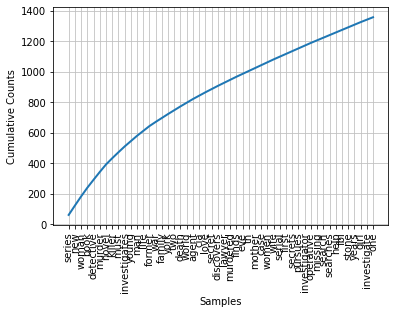

In [ ]:
# Veamos qué proporción del text está siendo ocupada por las 50 palabras más comunes

freq_dist_no_stop_words.plot(50, cumulative=True);

In [ ]:
# Palabras que sólo aparecen una sola vez

freq_dist_no_stop_words.hapaxes()[:20]

['puppies',
 'loom',
 'last',
 'grail',
 'poitiers',
 'tokyo',
 'punishes',
 'domestic',
 'aspiring',
 'resent',
 'draining',
 'weakening',
 'economy',
 'earthquake',
 'tests',
 'countrys',
 'jewish',
 'mishandling',
 'pregnant',
 'shows']

In [ ]:
# Palabras largas

unique = set(all_words_except_stop_words)
unique_series = pd.Series(list(unique))

unique_series

0          season
1             air
2         warming
3       countries
4        accident
          ...    
3060       cheats
3061    following
3062         mass
3063      emperor
3064       satire
Length: 3065, dtype: object

In [ ]:
unique_series[unique_series.str.len() > 15]

666       dissatisfactions
912       singersongwriter
1170      publicityseeking
1335    turnofthethcentury
1372     multigenerational
1611      mountainclimbing
1766     suicidebyaccident
1775      postthanksgiving
2897      counterterrorism
2976      autobiographical
dtype: object

In [ ]:
# Palabras largas que son frecuentes

larger_than_10 = unique_series.str.len() > 7
is_frequent = unique_series.apply(lambda x: freq_dist_no_stop_words[x] > 7)

unique_series[larger_than_10 & is_frequent]

32            together
37         investigate
121         characters
224           carolina
267          dangerous
334          detective
380     pseudonymously
496          terrorist
695       investigator
780      investigation
812           forensic
893          discovers
954          operative
1393     disappearance
1577      investigates
1641          searches
1705         manhattan
1709        washington
1862        barrington
2077        paranormal
2113         character
2368          assassin
2403          daughter
2453          american
2578          intrigue
2667          involved
2785          murdered
2799         daughters
2842        mysterious
3034          reporter
dtype: object

In [ ]:
# Podemos contar otras cosas, como la frecuencia de longitudes de nuestras palabras

freq_dist_lengths = nltk.FreqDist([len(w) for w in all_words_except_stop_words])

In [ ]:
freq_dist_lengths.most_common()

[(5, 1382),
 (6, 1364),
 (7, 1212),
 (4, 1051),
 (8, 707),
 (9, 586),
 (3, 471),
 (10, 354),
 (11, 164),
 (12, 157),
 (2, 60),
 (13, 60),
 (14, 30),
 (16, 11),
 (15, 11),
 (1, 8),
 (17, 2),
 (18, 1)]

In [ ]:
freq_dist_lengths.max()

5

In [ ]:
freq_dist_lengths[5]

1382

In [ ]:
# También podemos saber qué proporción del total de palabras tiene longitud de 5

freq_dist_lengths.freq(5)

0.18110339405058315

### Ejemplo 5: NLP y Visualizaciones

1. Objetivos:
    - Aprender qué visualizaciones podemos realizar de nuestros procesamientos de lenguaje natural
 
---
    
2. Desarrollo:

Como ya bien sabes, las visualizaciones son una parte esencial de nuestros análisis. Vamos a aprender cómo realizar algunas visualizaciones de los análisis estadísticos que ya hemos realizado. Esto nos ayudará a presentar nuestros hallazgos de manera más efectiva.

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Remoto Datasets/Remoto new_york_times_bestsellers-clean.json')

df.head()

,amazon_product_url,author,description,publisher,title,oid,bestsellers_date.numberLong,published_date.numberLong,rank.numberInt,rank_last_week.numberInt,weeks_on_list.numberInt,price.numberDouble
0,http://www.amazon.com/The-Host-Novel-Stephenie...,Stephenie Meyer,Aliens have taken control of the minds and bod...,"Little, Brown",THE HOST,5b4aa4ead3089013507db18c,1211587200000,1212883200000,2,1,3,25.99
1,http://www.amazon.com/Love-Youre-With-Emily-Gi...,Emily Giffin,A woman's happy marriage is shaken when she en...,St. Martin's,LOVE THE ONE YOU'RE WITH,5b4aa4ead3089013507db18d,1211587200000,1212883200000,3,2,2,24.95
2,http://www.amazon.com/The-Front-Garano-Patrici...,Patricia Cornwell,A Massachusetts state investigator and his tea...,Putnam,THE FRONT,5b4aa4ead3089013507db18e,1211587200000,1212883200000,4,0,1,22.95
3,http://www.amazon.com/Snuff-Chuck-Palahniuk/dp...,Chuck Palahniuk,An aging porn queens aims to cap her career by...,Doubleday,SNUFF,5b4aa4ead3089013507db18f,1211587200000,1212883200000,5,0,1,24.95
4,http://www.amazon.com/Sundays-at-Tiffanys-Jame...,James Patterson and Gabrielle Charbonnet,A woman finds an unexpected love,"Little, Brown",SUNDAYS AT TIFFANY’S,5b4aa4ead3089013507db190,1211587200000,1212883200000,6,3,4,24.99


In [ ]:
df['rank.numberInt'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14,  1, 11, 15, 16])

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
grouped_by_title = df.groupby('title')['description'].max()
grouped_by_title = grouped_by_title.str.lower()
grouped_by_title = grouped_by_title.str.strip()
grouped_by_title = grouped_by_title.str.replace('[^\w\s]', '')
grouped_by_title = grouped_by_title.str.replace('\d', '')
grouped_by_title = grouped_by_title.str.replace('\\n', '')
grouped_by_title = grouped_by_title.dropna()

tokenized = grouped_by_title.apply(nltk.word_tokenize)
all_words = tokenized.sum()

english_stop_words = stopwords.words('english')
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]

freq_dist = nltk.FreqDist(all_words_except_stop_words)

In [ ]:
most_common_20

array([['series', '61'],
       ['new', '61'],
       ['woman', '60'],
       ['book', '57'],
       ['detective', '52'],
       ['murder', '51'],
       ['novel', '49'],
       ['killer', '41'],
       ['must', '39'],
       ['investigates', '38'],
       ['young', '35'],
       ['man', '35'],
       ['life', '32'],
       ['former', '32'],
       ['war', '27'],
       ['family', '26'],
       ['york', '26'],
       ['two', '25'],
       ['death', '25'],
       ['world', '24']], dtype='<U12')

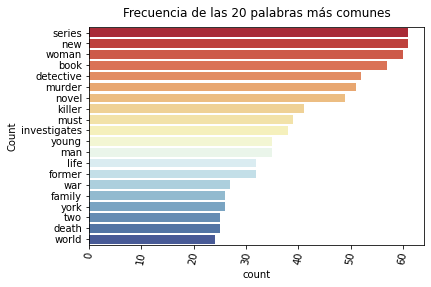

In [ ]:
# Podemos visualizar la frecuencia de las palabras más comunes

most_common_20 = pd.DataFrame(freq_dist.most_common(20), columns=['word','count'])

fig = plt.figure()
ax = fig.add_subplot()

sns.barplot(data = most_common_20, x = 'count', y = 'word', ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 palabras más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

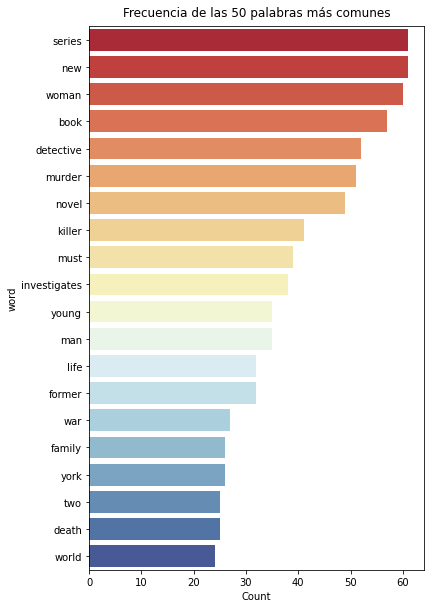

In [ ]:
most_common_50 = pd.DataFrame(freq_dist.most_common(50), columns=['word','count'])

fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot()

sns.barplot(data = most_common_50, x = 'count', y = 'word', ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 50 palabras más comunes', pad=10)
ax.set_xlabel('Count');

In [ ]:
# También podemos visualizar la frecuencia de los bigramas más comunes

text = nltk.Text(all_words)
freq_dist_bigrams = nltk.FreqDist(list(nltk.bigrams(text)))

freq_dist_bigrams

FreqDist({('detective', 'lindsay'): 4,
          ('lindsay', 'boxer'): 4,
          ('boxer', 'and'): 3,
          ('and', 'the'): 30,
          ('the', 'womens'): 3,
          ('womens', 'murder'): 3,
          ('murder', 'club'): 3,
          ('club', 'race'): 1,
          ('race', 'to'): 2,
          ('to', 'find'): 5,
          ('find', 'a'): 3,
          ('a', 'missing'): 9,
          ('missing', 'baby'): 1,
          ('baby', 'detective'): 1,
          ('club', 'investigate'): 2,
          ('investigate', 'a'): 4,
          ('a', 'possible'): 3,
          ('possible', 'serial'): 1,
          ('serial', 'killer'): 18,
          ('killer', 'puppies'): 1,
          ('puppies', 'and'): 1,
          ('and', 'an'): 9,
          ('an', 'exhusband'): 1,
          ('exhusband', 'loom'): 1,
          ('loom', 'large'): 1,
          ('large', 'in'): 1,
          ('in', 'the'): 99,
          ('the', 'last'): 1,
          ('last', 'installment'): 1,
          ('installment', 'of'): 2,
       

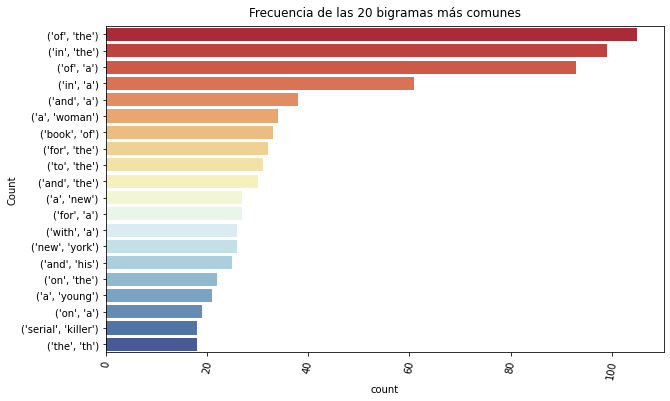

In [ ]:
most_common_20 = pd.DataFrame(freq_dist_bigrams.most_common(20), columns=['words','count'])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(data = most_common_20, x = 'count', y = 'words', ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 bigramas más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
# Probemos sin palabras vacías

text = nltk.Text(all_words_except_stop_words)
freq_dist_bigrams = nltk.FreqDist(list(nltk.bigrams(text)))

freq_dist_bigrams

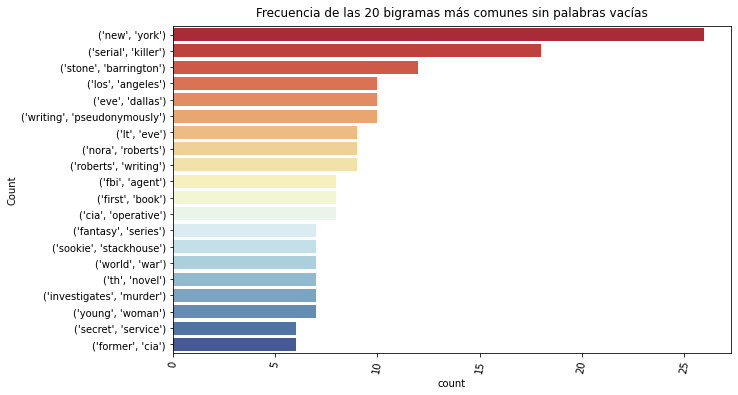

In [ ]:
most_common_20 = pd.DataFrame(freq_dist_bigrams.most_common(20), columns=['words','count'])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(data = most_common_20, x = 'count', y = 'words', ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 bigramas más comunes sin palabras vacías', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
# No estamos restringidos solamente a bigramas

from nltk.util import ngrams

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


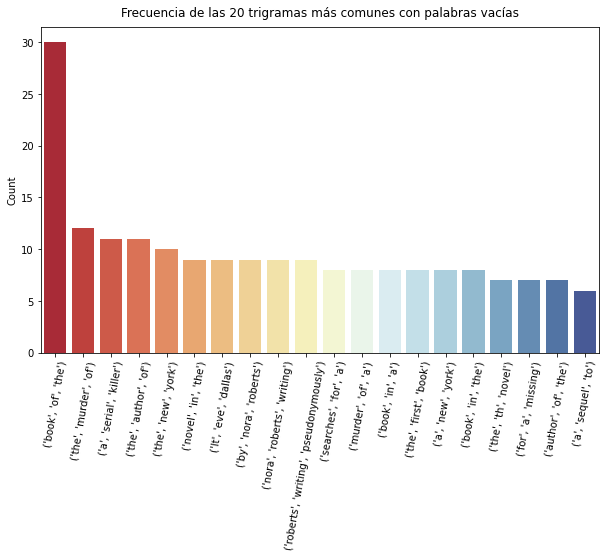

In [ ]:
text = nltk.Text(all_words)
freq_dist_trigrams = nltk.FreqDist(list(ngrams(text, 3)))

most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_trigrams.most_common(20))))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 0], most_common_20[:, 1], ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 trigramas más comunes con palabras vacías', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


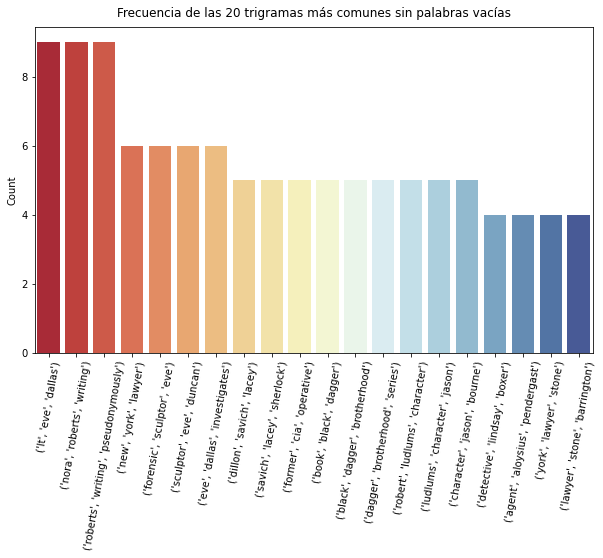

In [ ]:
text = nltk.Text(all_words_except_stop_words)
freq_dist_trigrams = nltk.FreqDist(list(ngrams(text, 3)))

most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_trigrams.most_common(20))))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 0], most_common_20[:, 1], ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 trigramas más comunes sin palabras vacías', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
# También podemos generar histogramas para visualizar la frecuencia de longitudes de palabras y oraciones

word_lengths = [len(w) for w in all_words_except_stop_words]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


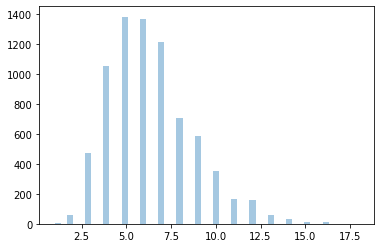

In [ ]:
sns.distplot(word_lengths, kde=False, norm_hist=False);

In [ ]:
sentence_lengths = grouped_by_title.apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


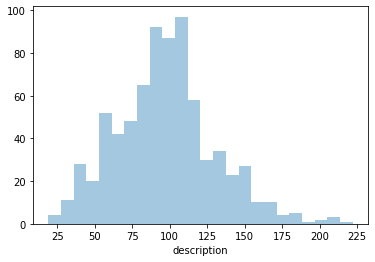

In [ ]:
sns.distplot(sentence_lengths, kde=False, norm_hist=False);

In [ ]:
num_of_words = grouped_by_title.str.split(' ').str.len()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


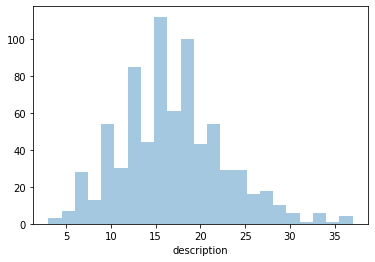

In [ ]:
sns.distplot(num_of_words, kde=False, norm_hist=False);

Para terminar, vamos a hacer una nube de palabras utilizando la librería `wordcloud`.

In [ ]:
from wordcloud import WordCloud

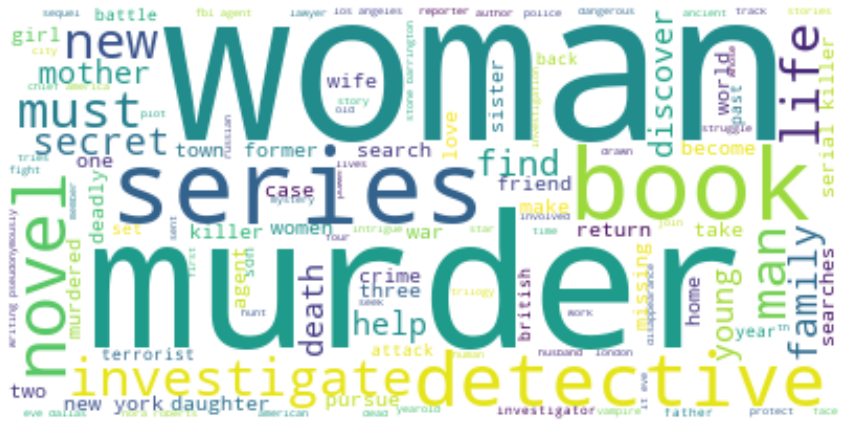

In [ ]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Reto 1: Pruebas A/B

1. Objetivos:
    - Practicar evaluar los resultados de una Prueba A/B
 
---
    
2. Desarrollo:

**a) Evaluando una prueba A/B de flujo de ventas**

El archivo 'ab_test-sales_pipeline-2' tiene datos muy similares a los que vimos en el último ejemplo. Estamos evaluando dos flujos de ventas distintos: A y B. Cada vez que alguien compró el producto gracias a uno de los dos flujos, se registró como un `1` en la columna `conversion` y un `0` en la columna `no conversion`.

Evalúa la prueba A/B para saber si los resultados obtenidos son estadísticamente significativos. El Reto consiste en los siguientes pasos:

1. Primero cuantifica cuál de los flujos de ventas fue más efectivo y en qué proporción.
2. Después aplica el test de permutación:
    1. Combina los resultados de ambos grupos en un mismo conjunto de datos
    2. Revuelve los datos
    3. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
    4. El resto de los datos conforman nuestro nuevo grupo B.
    5. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
    6. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.
3. Grafica tus resultados en un histograma y grafica una línea vertical que marque el resultado del experimento.
4. Cuantifica el Valor P y evalúa la significación estadística con un Alfa de 0.05 (5%).
5. Comenta tus hallazgos con tus compañeros y la experta.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Remoto Datasets/Remoto ab_test-sales_pipeline-2.csv')
df

,test,conversion,no conversion
0,A,0,1
1,B,0,1
2,A,0,1
3,A,0,1
4,B,0,1
...,...,...,...
76322,B,0,1
76323,A,0,1
76324,B,0,1
76325,B,1,0


In [ ]:
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()
total_count

,conversion,no conversion
test,,
A,4163,30576
B,4841,36747


Saquemos la proporción de conversiones que hubo comparadas con el total de pruebas que se realizaron:

In [ ]:
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])

total_count

,conversion,no conversion,success rate
test,,,
A,4163,30576,0.119836
B,4841,36747,0.116404


Con estos datos parecería que el flujo A (la hipótesis alternativa) es superior al flujo B. Veamos qué tan superior:

In [ ]:
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100

In [ ]:
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más `efectivo que el test B para generar ventas.')

El test A fue 2.86% más `efectivo que el test B para generar ventas.


¿Ahora, podemos entonces concluir que el flujo de ventas A es mejor que el B? No tan rápido. Vamos a aplicar un test de permutación para saber si nuestro hallazgo es estadísticamente significativo.

Primero tenemos que mezclar las mediciones del test A y el B en el mismo DataFrame. Esto ya está hecho, entonces solamente vamos a eliminar la columna 'test' para que no haya manera de diferenciarlos:

In [ ]:
all_measurements = df[['conversion', 'no conversion']]

Ahora necesitamos saber cuántos tests con el flujo A hubieron para poder generar muestras del mismo tamaño exactamente:

In [ ]:
value_counts = df['test'].value_counts()

value_counts

B    41588
A    34739
Name: test, dtype: int64

Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.

In [ ]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['A'], replace=False)
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    b = df.loc[~df.index.isin(a.index)]
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

In [ ]:
perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b
0,4104,30635,4900,36688
1,4047,30692,4957,36631
2,4150,30589,4854,36734
3,4195,30544,4809,36779
4,4133,30606,4871,36717
...,...,...,...,...
995,4125,30614,4879,36709
996,4072,30667,4932,36656
997,4161,30578,4843,36745
998,4091,30648,4913,36675


In [ ]:
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [ ]:
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,4104,30635,4900,36688,0.118138,0.117822
1,4047,30692,4957,36631,0.116497,0.119193
2,4150,30589,4854,36734,0.119462,0.116716
3,4195,30544,4809,36779,0.120758,0.115634
4,4133,30606,4871,36717,0.118973,0.117125
...,...,...,...,...,...,...
995,4125,30614,4879,36709,0.118743,0.117317
996,4072,30667,4932,36656,0.117217,0.118592
997,4161,30578,4843,36745,0.119779,0.116452
998,4091,30648,4913,36675,0.117764,0.118135


In [ ]:
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,4104,30635,4900,36688,0.118138,0.117822,0.002672
1,4047,30692,4957,36631,0.116497,0.119193,-0.023140
2,4150,30589,4854,36734,0.119462,0.116716,0.022986
3,4195,30544,4809,36779,0.120758,0.115634,0.042427
4,4133,30606,4871,36717,0.118973,0.117125,0.015531
...,...,...,...,...,...,...,...
995,4125,30614,4879,36709,0.118743,0.117317,0.012002
996,4072,30667,4932,36656,0.117217,0.118592,-0.011730
997,4161,30578,4843,36745,0.119779,0.116452,0.027777
998,4091,30648,4913,36675,0.117764,0.118135,-0.003152


Ya tenemos nuestros resultados, vamos a ver dónde cae en nuestra distribución el resultado que obtuvimos en nuestro experimento:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


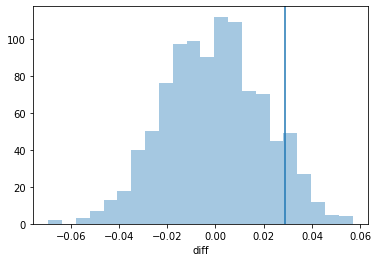

In [ ]:
sns.distplot(perm_results['diff'], kde=False, norm_hist=False)

plt.axvline(diferencia_en_proporcion);

Solamente de ver la histograma podemos concluir que nuestro resultado es de hecho bastante típico. Un gran número de modelos realizados totalmente al azar tuvieron valores iguales o más extremos que el que obtuvimos en nuestro experimento.

Vamos ahora a obtener el Valor P para cuantificar numéricamente nuestro resultado:

In [ ]:
(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0]

0.094

### Reto 2: Regex

1. Objetivos:
    - Practicar expresiones regulares con un conjunto de datos real
 
---
    
2. Desarrollo:

Vamos a practicar expresiones regulares utilizando un conjunto de datos llamado 'amazon_fine_food_reviews-clean.csv'. Este conjunto de datos es en realidad un subconjunto de un conjunto más grande que proviene de [esta fuente](https://www.kaggle.com/snap/amazon-fine-food-reviews). Contiene evaluaciones de muchos diversos productos realizadas por usuarios de Amazon. La columna 'text' contiene el texto de la evaluación, y ésa es la columna que nos interesa.

Vamos a practicar expresiones regulares con esa columna. Con cada búsqueda que realices vas a obtener un nuevo subconjunto de datos de un tamaño específico. Al terminar tus búsquedas compara el tamaño de tus subconjuntos de datos con los de tus compañeros, para checar que tus respuestas fueron correctas.

Tu Reto es entonces obtener subconjunto de datos que tengan estas características:

1. Todas las evaluaciones que contengan la palabra 'food' (en minúsculas).
2. Todas las evaluaciones que contengan algún número de dos digitos.
3. Todas las evaluaciones que contengan algún porcentaje (uno o más digitos seguidos de un signo de porcentaje).
4. Todas las evaluaciones que comiencen con la palabra 'Dog' o 'dog'.
5. Todas las evaluaciones que terminen con el fragmento 'awesome.' (fíjate que hay específicamente un punto después de la palabra 'awesome').
6. Todas las evaluaciones que contengan las palabras 'horrible' **o** 'terrible'.
7. Todas las evaluaciones que contengan **solamente** letras minúsculas.

Después de realizar estas exploraciones, limpia tu conjunto de datos para remover lo siguiente de todos tus textos:

1. Cualquier forma parecida a la siguiente: `<br>` o `<br/>` (revisa variaciones de estos tags, con espacios intermedios, por ejemplo)
2. Signos en general
3. Digitos
4. Cualquier otra cosa que no te parezca relevante para nuestro análisis de lenguaje natural

También convierte todas las letras en minúsculas para homogeneizar nuestro conjunto de datos.

Guarda tu conjunto de datos como un archivo 'csv' para que lo puedas utilizar en los próximos retos (asegúrate de incluir **por lo menos** las columnas 'text' y 'score'.

### Reto 3: Nltk Text

1. Objetivos:
    - Practicar el uso del objeto Text de la librería Nltk
 
---
    
2. Desarrollo:

Vamos a practicar utilizar el objeto Text de la librería Nltk. Para practicar utilizaremos el conjunto de datos que limpiaste en el Reto anterior. Este conjunto de datos debería de contener todas las evaluaciones registradas en el dataset 'amazon_fine_food_reviews-clean.csv' ya limpias y listas para el análisis.

Tu Reto consiste en lo siguiente:

1. Aplica el método 'word_tokenize' de nltk para separar todas las evaluaciones por palabras (esto puede tardar un ratito).
2. Genera una sola lista con todas las listas que obtuviste en el paso 1 y úsala para crear un objeto `nltk.Text` (esto también puede tardar un ratito, sé paciente).
3. Busca las concordancias de las palabras 'boy' y 'girl'.
4. Busca las palabras que tengan contextos similares a las palabras 'boy' y 'girl'.
5. Busca los contextos que tengan en común las palabras 'boy' y 'girl'.
6. Cuantifica la riqueza léxica de tu conjunto de datos
7. Sigue tu curiosidad y realiza algunas otras exploraciones por tu cuenta.
8. Comenta tus hallazgos con tus compañeros y la experta.

In [ ]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Remoto Datasets/Remoto amazon_fine_food_reviews-clean.csv')
df.head(2)

,id,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,time,summary,text
0,258510,B00168V34W,A1672LH9S1XO70,"Lorna J. Loomis ""Canadian Dog Fancier""",13,14,3,1266796800,"Misleading to refer to ""PODS""","This coffee does NOT come in individual ""PODS""..."
1,207915,B000CQID2Y,A42CJC66XO0H7,"Scott Schimmel ""A Butterfly Dreaming""",2,2,5,1279497600,Delicious,I was a little skeptical after looking at the ...


In [ ]:
grouped_by_title = df.groupby('profile_name')['text'].max()
grouped_by_title

profile_name
! MR. KNOW IT ALL  ;-b "DR SHOCK"                   I enjoy cereal and this cereal is like most su...
"dmab6395"                                          I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...
"lisah_007"                                         Short and sweet (or in this case salty) - by f...
#1 Amazon Fan                                       I was a little hesitant to try these, especial...
$$$saver                                            My 10 month old baby absolutly loves the lil c...
                                                                          ...                        
zzzed                                               Rcv'd on 20/Nov/06 product w expiry date of 23...
~ Z ~                                               I have four dogs ranging from a 7 pound Chihua...
~beto.kw~                                           i got the butter in chunks , it has a nice cho...
~~Hummingbirder~~ "Call me hb"                      This tea brews a 

Primero hay que limpiar un poco nuestros textos:

In [ ]:
grouped_by_title = grouped_by_title.str.lower()
grouped_by_title = grouped_by_title.str.strip()
grouped_by_title = grouped_by_title.str.replace('[^\w\s]', '', regex=True)
grouped_by_title = grouped_by_title.str.replace('\d', '')
grouped_by_title = grouped_by_title.str.replace('\\n', '')
grouped_by_title = grouped_by_title.dropna()

grouped_by_title

profile_name
! MR. KNOW IT ALL  ;-b "DR SHOCK"                   i enjoy cereal and this cereal is like most su...
"dmab6395"                                          i thought this movie was so funny michael keat...
"lisah_007"                                         short and sweet or in this case salty  by far ...
#1 Amazon Fan                                       i was a little hesitant to try these especiall...
$$$saver                                            my  month old baby absolutly loves the lil cru...
                                                                          ...                        
zzzed                                               rcvd on nov product w expiry date of jan two m...
~ Z ~                                               i have four dogs ranging from a  pound chihuah...
~beto.kw~                                           i got the butter in chunks  it has a nice choc...
~~Hummingbirder~~ "Call me hb"                      this tea brews a 

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenized = grouped_by_title.apply(nltk.word_tokenize)
tokenized

profile_name
! MR. KNOW IT ALL  ;-b "DR SHOCK"                   [i, enjoy, cereal, and, this, cereal, is, like...
"dmab6395"                                          [i, thought, this, movie, was, so, funny, mich...
"lisah_007"                                         [short, and, sweet, or, in, this, case, salty,...
#1 Amazon Fan                                       [i, was, a, little, hesitant, to, try, these, ...
$$$saver                                            [my, month, old, baby, absolutly, loves, the, ...
                                                                          ...                        
zzzed                                               [rcvd, on, nov, product, w, expiry, date, of, ...
~ Z ~                                               [i, have, four, dogs, ranging, from, a, pound,...
~beto.kw~                                           [i, got, the, butter, in, chunks, it, has, a, ...
~~Hummingbirder~~ "Call me hb"                      [this, tea, brews

In [ ]:
all_words = tokenized.sum()
text = nltk.Text(all_words)
text

<Text: i enjoy cereal and this cereal is like...>

In [ ]:
text.concordance('boy', lines=20)

Displaying 20 of 58 matches:
ery came quickly and i served the can boy my cat loved the food so much he lick
the pet waste biobag can be tossed in boy i am glad i called the city before pu
t i might singe my nose hairs because boy is it strong you people who drink it 
honey and peanuts going for thembr br boy was i disappointed i thought this cer
ould never have made the purchase and boy was i glad to take the advice prior t
the past with store bought brands and boy did i regret it haha if you dont have
r suited for a gi joe figurine than a boy the recommendation when we bought our
ree and gluten eaters in our home and boy am i glad we ordered of these from am
mell and a delight to give to my good boy my husband and two boys used to eat t
ouple of days i immedately fed it and boy did it come alive fast and furious i 
ve been buying it there lately my big boy lbs was put on an allmeat diet and he
ed down version of real coconut water boy was i wrong what i got was a very swe
 red inflam

In [ ]:
text.concordance('girl', lines=20)

Displaying 20 of 64 matches:
fetti cake for a bridal shower for a girl whose colors were hot pink and black
lly i am a made from scratch kind of girl but wanted to try these flavors and 
family out entertain teen girls with girl talk time and go go go thanks to the
s food to be a lifesaver for her old girl my husband and i enjoy trying variou
 trailers were coming over i had the girl with three boobs from the freak show
 by good people my overweight little girl not only got down to a healthy size 
hearing about this product on hungry girl i love peanut butter but not all tha
ht this toy a year ago for my golden girl who would wolf down her food and for
s get about cup dry per daybr the yo girl gets about cup dry per daybr br i th
y store dry its the only reason baby girl is still alive if you cant afford he
ven though shes getting to be an old girl shes amazingly healthy i used to use
tinky in the last weeks with the new girl i was steadily switching over her fr
witch to natural balanc

In [ ]:
text.similar('boy')

i it there that he this flavor she and but so one shipping amazon dog
they taste salt price when


In [ ]:
text.similar('girl')

dog coffee time one flavor taste tea food dogs cat product door price
daughter mouth stuff packets wife and but


In [ ]:
# common_contexts regresa los contextos que comparten dos o más palabras
text.common_contexts(['boy', 'girl'])

little_i


In [ ]:
len(text)

956846

In [ ]:
len(set(text))

29310

In [ ]:
len(set(text)) / len(text)

0.030631888517065442

### Reto 4: Nltk FreqDist y Visualizaciones de NLP

1. Objetivos:
    - Aprender a realizar análisis estadístico de datos no estructurados utilizando FreqDist
    - Utilizar seaborn para visualizar los análisis estadísticos que visualicemos
 
---
    
2. Desarrollo:

Vamos a utilizar el objeto `FreqDist` para hacer análisis estadístico de las mismas evaluaciones que has utilizado en los últimos Retos. Intercalaremos análisis puramente numérico con visualizaciones realizadas con `seaborn` y `matplotlib` para hacer más claros nuestros hallazgos.

Tu Reto consiste en lo siguiente:

1. Tokeniza las evaluaciones y crea una sola lista que contenga todas las palabras en nuestro conjunto de datos.
2. Utiliza el objeto `stopwords` encontrado en la librería `nltk.corpus` para filtrar todas las palabras vacías de tu conjunto de datos y solamente tener palabras relevantes.
3. Crea un objeto `Text` con tu dataset resultante.
4. Crea también un objeto `FreqDist` con el mismo dataset.
5. Obtén las 20 palabras más comunes en el dataset y realiza una gráfica de barras 'verticales' para visualizar su frecuencia.
6. Obtén las 50 palabras más comunes en el dataset y realiza una gráfica de barras 'horizontales' para visualizar su frecuencia.
7. Obtén los 20 bigramas más frecuentes en el dataset y realiza una gráfica de barras 'verticales' para visualizar tu frecuencia.
8. Obtén una lista de las palabras que tengan 10 o más caracteres que aparezcan por lo menos 7 veces en el dataset.
9. Realiza un histograma del número de palabras contenidas en cada evaluación.
10. Genera una nube de palabras con tu dataset.

In [ ]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Remoto Datasets/Remoto amazon_fine_food_reviews-clean.csv')
df.head(2)

,id,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,time,summary,text
0,258510,B00168V34W,A1672LH9S1XO70,"Lorna J. Loomis ""Canadian Dog Fancier""",13,14,3,1266796800,"Misleading to refer to ""PODS""","This coffee does NOT come in individual ""PODS""..."
1,207915,B000CQID2Y,A42CJC66XO0H7,"Scott Schimmel ""A Butterfly Dreaming""",2,2,5,1279497600,Delicious,I was a little skeptical after looking at the ...


In [ ]:
grouped_by_title = df.groupby('profile_name')['text'].max()
grouped_by_title

profile_name
! MR. KNOW IT ALL  ;-b "DR SHOCK"                   I enjoy cereal and this cereal is like most su...
"dmab6395"                                          I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...
"lisah_007"                                         Short and sweet (or in this case salty) - by f...
#1 Amazon Fan                                       I was a little hesitant to try these, especial...
$$$saver                                            My 10 month old baby absolutly loves the lil c...
                                                                          ...                        
zzzed                                               Rcv'd on 20/Nov/06 product w expiry date of 23...
~ Z ~                                               I have four dogs ranging from a 7 pound Chihua...
~beto.kw~                                           i got the butter in chunks , it has a nice cho...
~~Hummingbirder~~ "Call me hb"                      This tea brews a 

Primero hay que limpiar un poco nuestros textos:

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
grouped_by_title = grouped_by_title.str.lower()
grouped_by_title = grouped_by_title.str.strip()
grouped_by_title = grouped_by_title.str.replace('[^\w\s]', '', regex=True)
grouped_by_title = grouped_by_title.str.replace('\d', '')
grouped_by_title = grouped_by_title.str.replace('\\n', '')
grouped_by_title = grouped_by_title.dropna()

tokenized = grouped_by_title.apply(nltk.word_tokenize)
all_words = tokenized.sum()

english_stop_words = stopwords.words('english')
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]

freq_dist = nltk.FreqDist(all_words_except_stop_words)

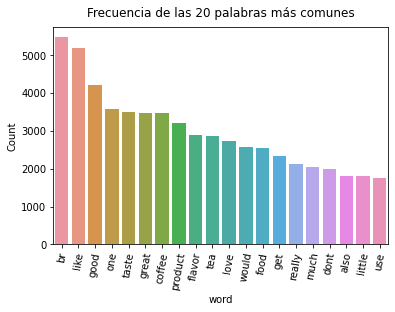

In [ ]:
most_common_20 = pd.DataFrame(freq_dist.most_common(20), columns=['word','count'])

fig = plt.figure()
ax = fig.add_subplot()

sns.barplot(data = most_common_20, x = 'word', y = 'count', ax=ax);
ax.set_title('Frecuencia de las 20 palabras más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

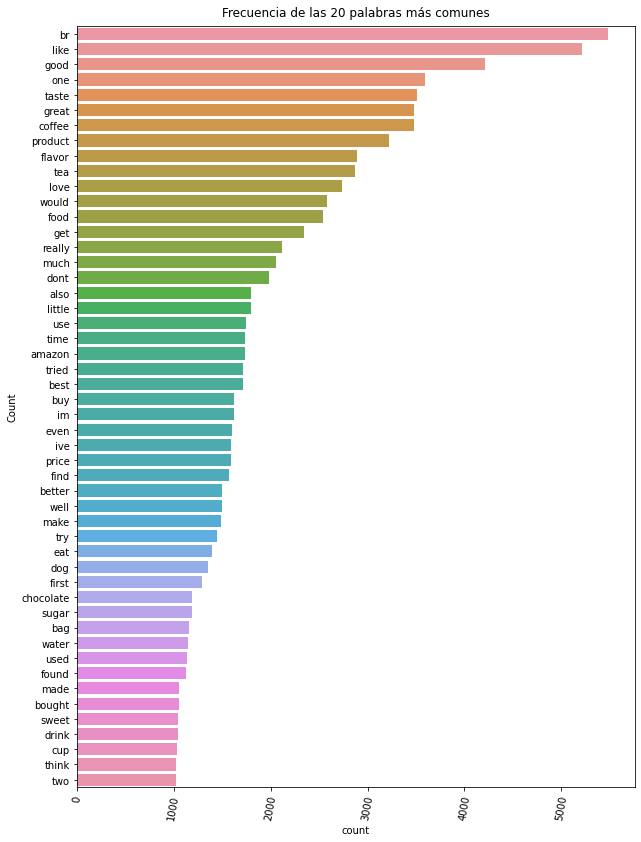

In [ ]:
most_common_50 = pd.DataFrame(freq_dist.most_common(50), columns=['word','count'])

fig = plt.figure(figsize=(10,14))
ax = fig.add_subplot()

sns.barplot(data = most_common_50, x = 'count', y = 'word', ax=ax);
ax.set_title('Frecuencia de las 20 palabras más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
text = nltk.Text(all_words_except_stop_words)
freq_dist_bigrams = nltk.FreqDist(list(nltk.bigrams(text)))

freq_dist_bigrams

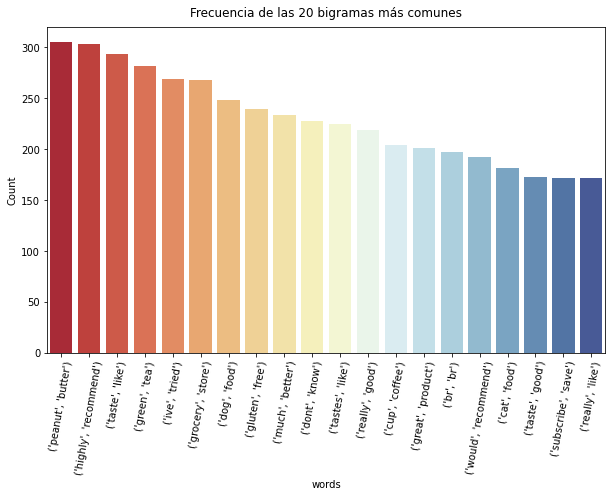

In [ ]:
most_common_20 = pd.DataFrame(freq_dist_bigrams.most_common(20), columns=['words','count'])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(data = most_common_20, x = 'words', y = 'count', ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 bigramas más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
all_words_except_stop_words

In [ ]:
palabras_10 = [word for word in all_words_except_stop_words if len(word) >= 10]
freq_dist_10 = nltk.FreqDist(palabras_10)
freq_dist_10_7 = [(key, freq_dist_10[key]) for key in freq_dist_10 if freq_dist_10[key] >=7]
freq_dist_10_7

[('beetlejuice', 16),
 ('seasonings', 45),
 ('especially', 324),
 ('preferences', 14),
 ('alternatives', 21),
 ('preference', 47),
 ('definitely', 634),
 ('subjective', 10),
 ('approximately', 21),
 ('discovered', 137),
 ('everything', 273),
 ('inexpensive', 29),
 ('completely', 156),
 ('difference', 231),
 ('comparison', 61),
 ('exclusively', 26),
 ('restaurant', 62),
 ('containers', 63),
 ('experience', 159),
 ('interested', 56),
 ('opportunity', 18),
 ('lowcalorie', 7),
 ('perspective', 10),
 ('ridiculous', 28),
 ('recommendation', 34),
 ('purchasing', 125),
 ('thankfully', 21),
 ('directions', 74),
 ('ingredients', 676),
 ('antioxidant', 16),
 ('flavonoids', 22),
 ('antioxidants', 46),
 ('refreshing', 125),
 ('consistently', 23),
 ('experienced', 39),
 ('sensitivity', 9),
 ('unfortunately', 197),
 ('purchasebr', 7),
 ('additional', 56),
 ('disappointed', 345),
 ('pleasantly', 83),
 ('automatically', 17),
 ('definately', 31),
 ('transaction', 12),
 ('artificial', 219),
 ('wonderfull

In [ ]:
word_lengths

In [ ]:
mayores_10 =  all_words_except_stop_words[word_lengths > 10]

In [ ]:
from wordcloud import WordCloud

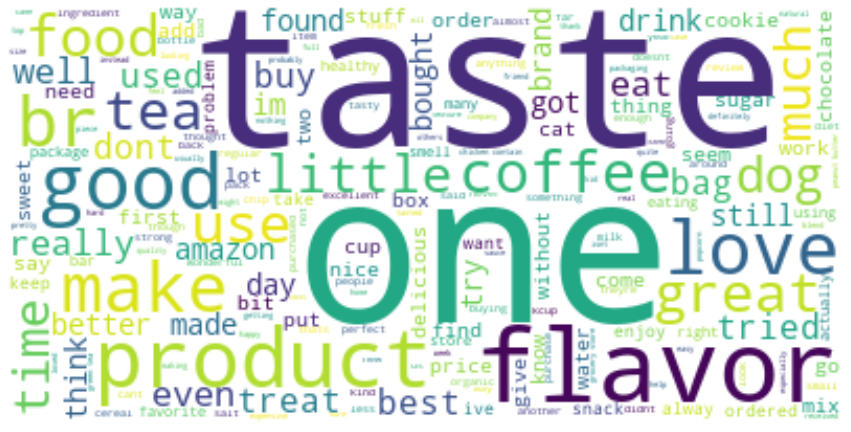

In [ ]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()